# CAB420 - Plot Gallery
## Part 2: Regression Plots
Dr Simon Denman (s.denman@qut.edu.au)

## Overview

This is part 2 of the plot gallery. This one focuses on regression, and the sort of plots that you might use for this. The overview here is very brief as the main details really are all below with each plot.

In [1]:
from sklearn.datasets import make_classification, make_regression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import scipy.stats as stats
import numpy

## Making some fake data, and models

Cause we need something to plot. And then'll fit a regressor or three. For our regressors we'll go for
* A linear regressor, applied to linear data, that will work well
* A linear regressor, applied to non-linear data, that will work not so well
* A regularised regressor, applied to linear data, that will work well

For the first and third we'll also standardise the data. I won't bother with the second broken linear model as it's very simple (one predictor, one response) and I'm just creating this to show some more variety in the various plots.

Please note that the aim here is not to dive deep into the properties of these models, but just to create a few models that show some variety in the plots.

In [2]:
# create some pretend data
# data contains a bunch of redundant and uninformative terms, and a lot of noise
X_reg, y_reg = make_regression(random_state=42, n_samples=2000, n_features=100, n_informative=25, 
                               effective_rank=30, n_targets=1, bias=0.2, tail_strength=0.5, noise=10)
y_reg = y_reg.reshape(-1, 1)
# split into train, validation and test
X_train, X_other, y_train, y_other = train_test_split(X_reg, y_reg, train_size=0.7, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_other, y_other, train_size=0.5, random_state=42)

# create a second, broken set of data
# this one is very simple
numpy.random.seed(42)
X_broken = numpy.linspace(0, numpy.pi * 0.5, 1000)
y_broken = numpy.sin(X_broken) + numpy.random.randn(*X_broken.shape) * 0.02
X_broken_train, X_other, y_broken_train, y_other = train_test_split(X_broken, y_broken, train_size=0.7, random_state=42)
X_broken_val, X_broken_test, y_broken_val, y_broken_test = train_test_split(X_other, y_other, train_size=0.5, random_state=42)

# standardise the data - just on the larger dataset
# first compute the mean and std.dev on the training set
x_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train)
# then apply this to everything
# standardise X data
X_train_std = x_scaler.transform(X_train)
X_val_std = x_scaler.transform(X_val)
X_test_std = x_scaler.transform(X_test)
# standardise y data
y_train_std = y_scaler.transform(y_train)
y_val_std = y_scaler.transform(y_val)
y_test_std = y_scaler.transform(y_test)

# fit the linear model
linear_model = sm.OLS(y_train_std, X_train_std).fit()
# fit the linear model on the broken data (not standardised)
linear_model_broken = sm.OLS(y_broken_train, X_broken_train).fit()

# fit the regularised model
# range of lambda values
lambdas = numpy.logspace(-5, 1, 50)

# loop through lambdas, fitting models and measuring accuracy
coeff = []
train_rmse = []
val_rmse = []
for l in lambdas:
    ted = sm.OLS(y_train_std, X_train_std).fit_regularized(alpha=l, L1_wt=1.0)
    coeff.append(ted.params)
    train_rmse.append(numpy.sqrt(numpy.mean((ted.predict(X_train_std) - y_train_std.reshape(-1))**2)))
    val_rmse.append(numpy.sqrt(numpy.mean((ted.predict(X_val_std) - y_val_std.reshape(-1))**2)))

# get best lambda
best_lasso_lambda = lambdas[val_rmse.index(min(val_rmse))]
# and fit final regularised model
regularised_model = sm.OLS(y_train_std, X_train_std).fit_regularized(alpha=best_lasso_lambda, L1_wt=1.0)

# make some predictions for all models
# good linear
pred_linear_train = linear_model.predict(X_train_std)
pred_linear_val = linear_model.predict(X_val_std)
pred_linear_test = linear_model.predict(X_test_std)

# broken linear
pred_linear_broken_train = linear_model_broken.predict(X_broken_train)
pred_linear_broken_val = linear_model_broken.predict(X_broken_val)
pred_linear_broken_test = linear_model_broken.predict(X_broken_test)

# regularised linear
pred_regular_train = regularised_model.predict(X_train_std)
pred_regular_val = regularised_model.predict(X_val_std)
pred_regular_test = regularised_model.predict(X_test_std)

### Line Plots for Regression Predictions

Text(0.5, 1.0, 'Testing Data (Broken Model)')

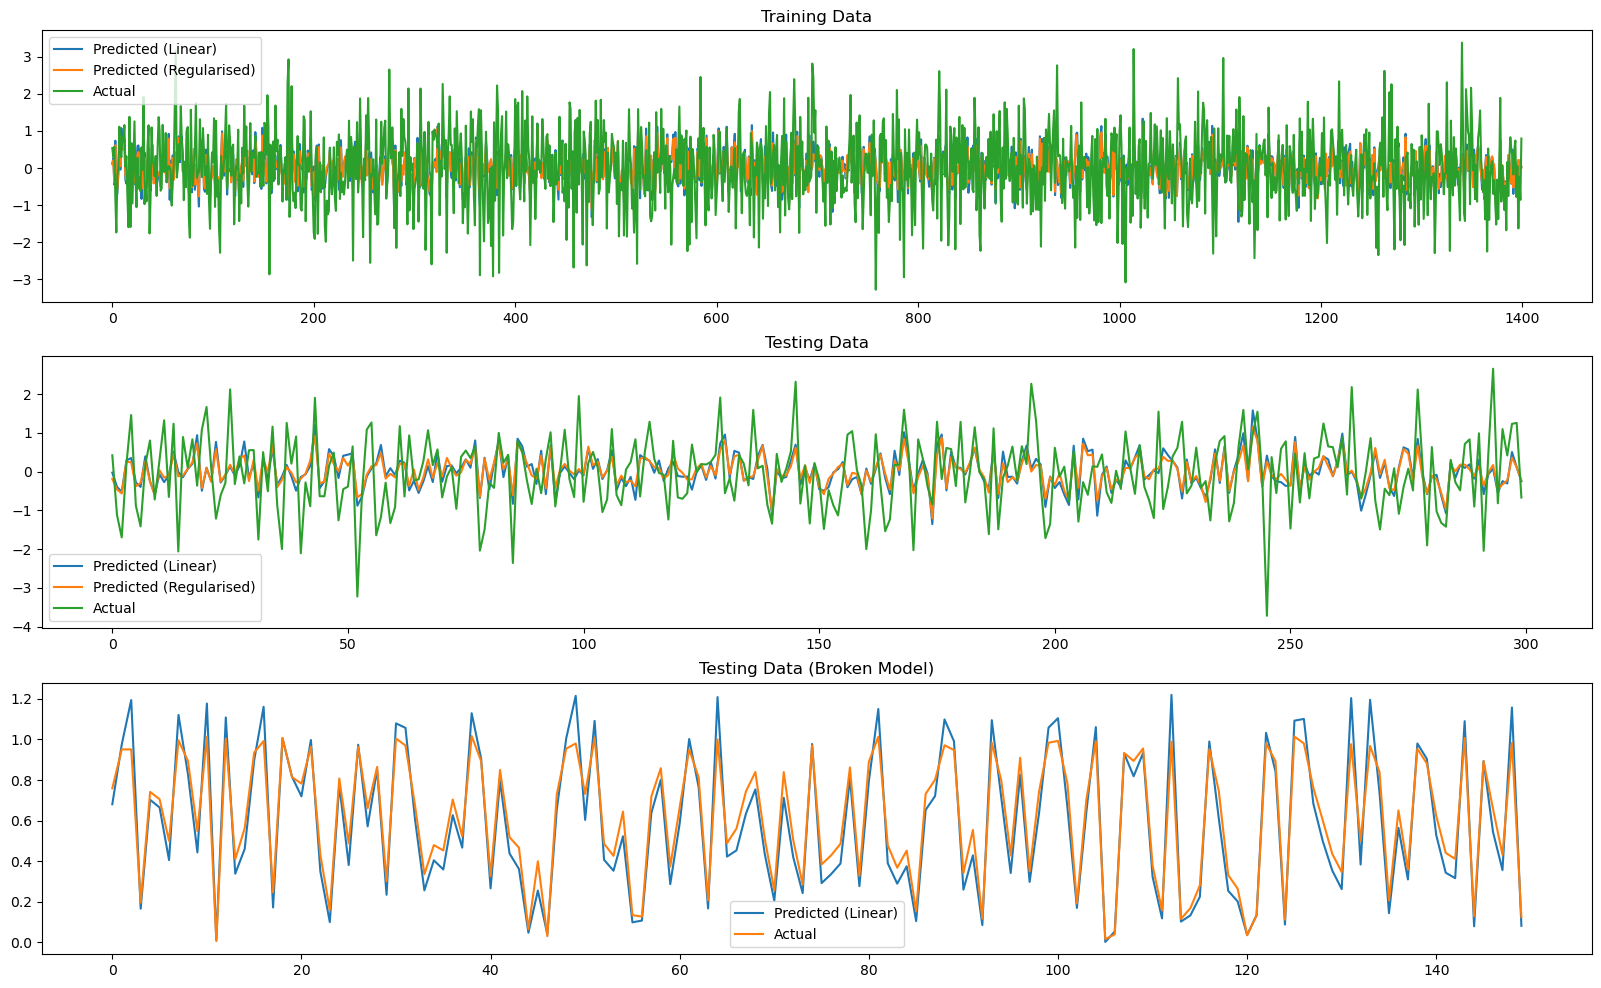

In [3]:
fig = plt.figure(figsize=[20, 12])
ax = fig.add_subplot(3, 1, 1)
ax.plot(pred_linear_train, label='Predicted (Linear)')
ax.plot(pred_regular_train, label='Predicted (Regularised)')
ax.plot(y_train_std, label='Actual')
ax.legend()
ax.set_title('Training Data')

ax = fig.add_subplot(3, 1, 2)
ax.plot(pred_linear_test, label='Predicted (Linear)')
ax.plot(pred_regular_test, label='Predicted (Regularised)')
ax.plot(y_test_std, label='Actual')
ax.legend()
ax.set_title('Testing Data')

ax = fig.add_subplot(3, 1, 3)
ax.plot(pred_linear_broken_test, label='Predicted (Linear)')
ax.plot(y_broken_test, label='Actual')
ax.legend()
ax.set_title('Testing Data (Broken Model)')

**What's it show?**
The predicted and actual value for each sample. By virtue of being a line plot, it implies a relationship between consecutive samples. I will note that none of our data has such a relationship.

**When would you use it?**
When you have data where consecutive samples are related (i.e. daily data) such that the order of the data has some meaning. Also tends to work better with smaller datasets, the plot on the training set for example (first row) is just a mess of lines due to the large number of points.

**What does it not show?**
Any trends in errors are hard to see, particularly when there are a lot of points shown like with the training data.

### Scatter Plots for Regression Predictions

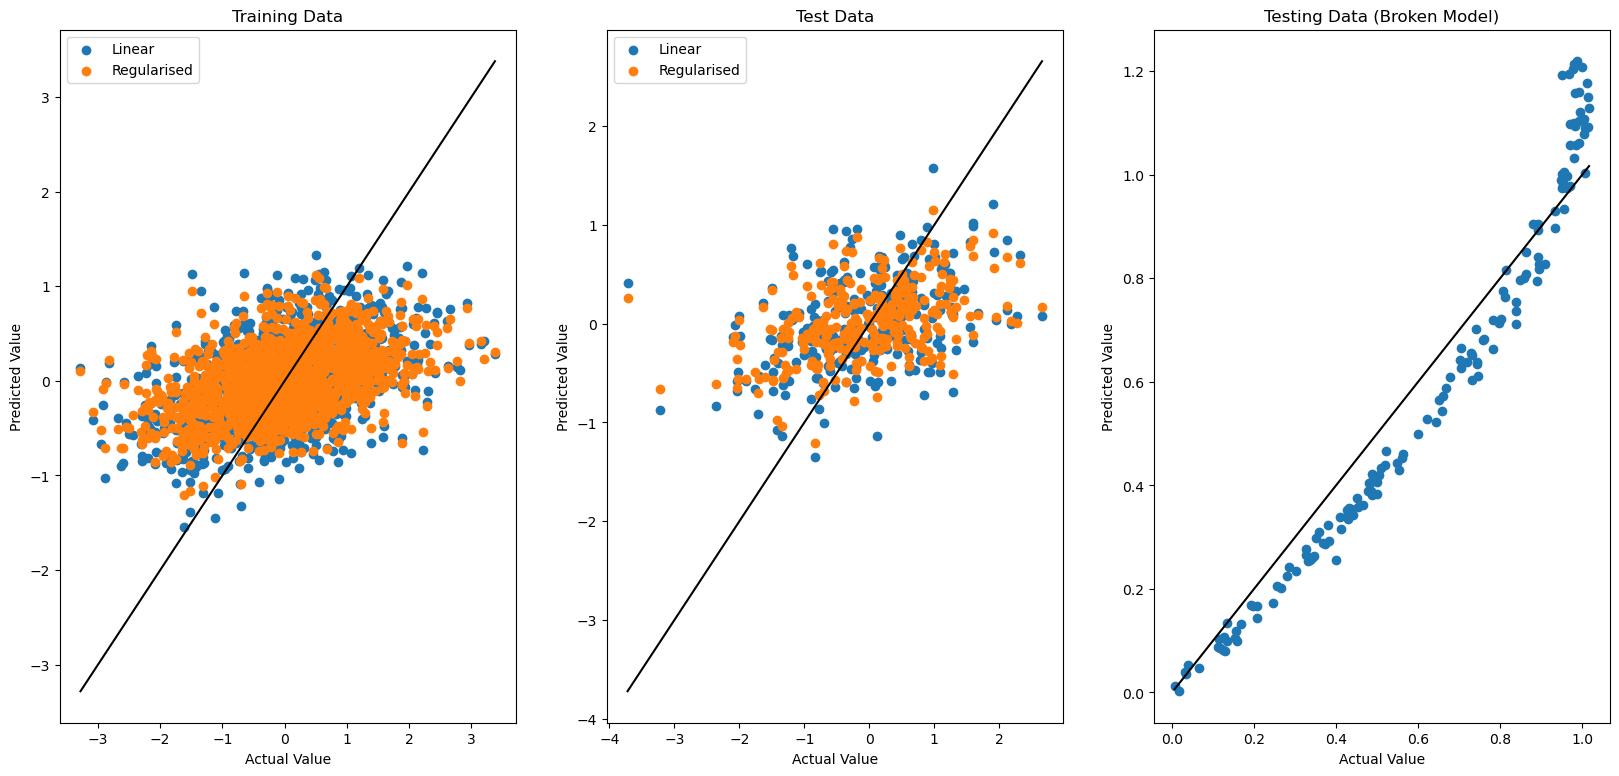

In [4]:
fig = plt.figure(figsize=[20, 9])
ax = fig.add_subplot(1, 3, 1)
ax.scatter(y_train_std, pred_linear_train, label='Linear')
ax.scatter(y_train_std, pred_regular_train, label='Regularised')
ax.plot(numpy.unique(y_train_std), numpy.unique(y_train_std), color='black')
ax.set_xlabel('Actual Value')
ax.set_ylabel('Predicted Value')
ax.legend()
ax.set_title('Training Data')

ax = fig.add_subplot(1, 3, 2)
ax.scatter(y_test_std, pred_linear_test, label='Linear')
ax.scatter(y_test_std, pred_regular_test, label='Regularised')
ax.plot(numpy.unique(y_test_std), numpy.unique(y_test_std), color='black')
ax.set_xlabel('Actual Value')
ax.set_ylabel('Predicted Value')
ax.legend()
ax.set_title('Test Data')

ax = fig.add_subplot(1, 3, 3)
ax.scatter(y_broken_test, pred_linear_broken_test)
ax.plot(numpy.unique(y_broken_test), numpy.unique(y_broken_test), color='black')
ax.set_xlabel('Actual Value')
ax.set_ylabel('Predicted Value')
ax.set_title('Testing Data (Broken Model)');

**What's it show?**
The relationship between the predicted and actual values. Multiple models can be visualised on a plot if you want, though it gets busy. This plot gives a good sense of how well the predictions follow the true values in general, though any relationships between points is lost. Generally scales better to large sets than the line plot. It also allows you see possible non-linear trends in the data, such as the curve in the plot for the broken model (far right).

**When would you use it?**
When looking at regression performance and how well data fits a model, in particular when the order of the data is not important / has no meaning. 

**What does it not show?**
Anything really about model validity. 

### QQ-Plots

Text(0.5, 1.0, 'Broken Linear Model, using residuals computed during fitting')

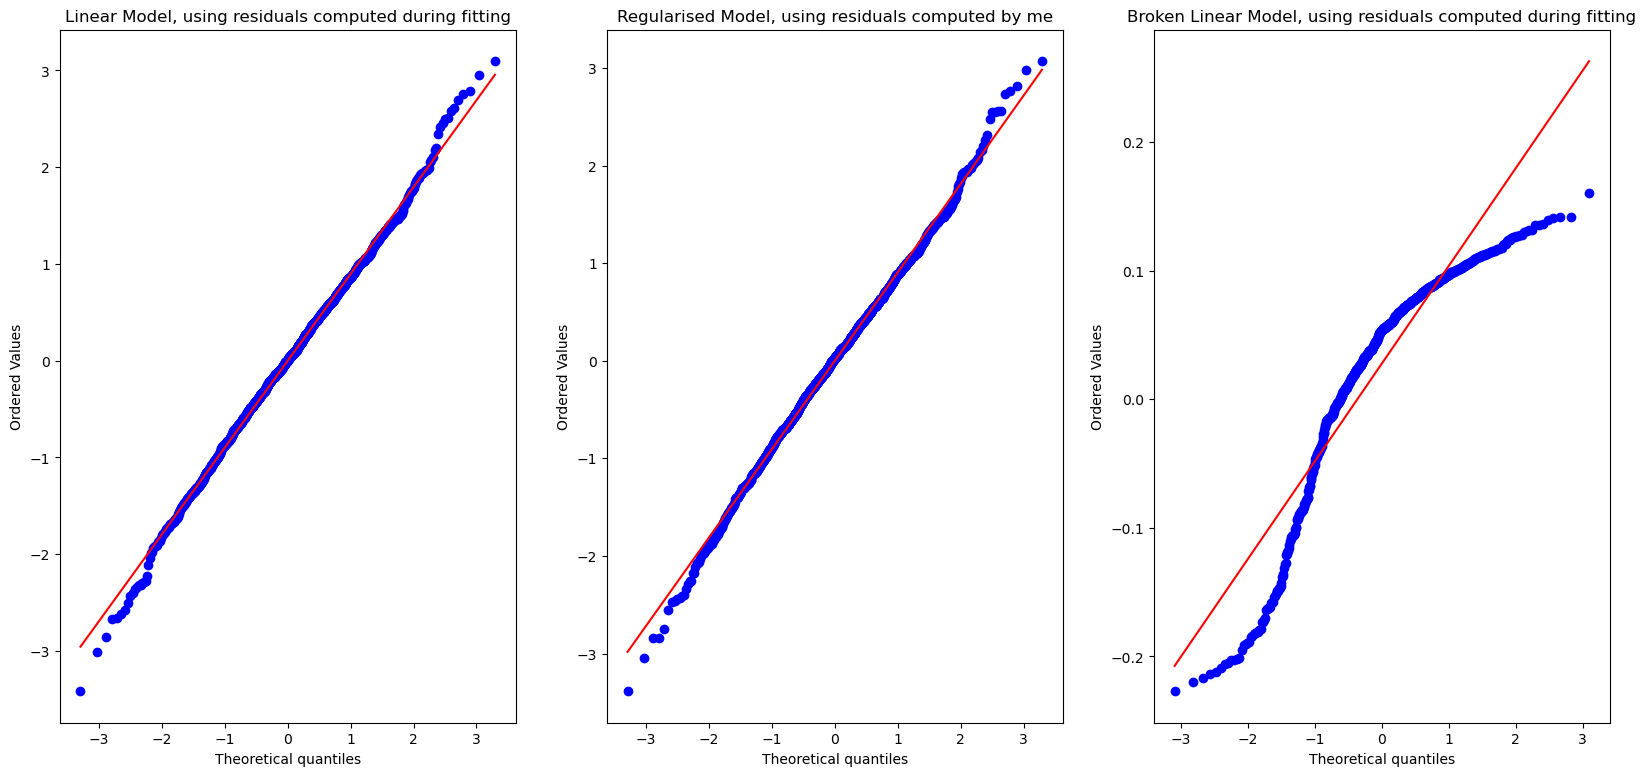

In [5]:
fig = plt.figure(figsize=[20, 9])    

ax = fig.add_subplot(1, 3, 1)
stats.probplot(linear_model.resid, dist="norm", plot=ax)
ax.set_title('Linear Model, using residuals computed during fitting') 

ax = fig.add_subplot(1, 3, 2)
stats.probplot(y_train_std.reshape(-1) - regularised_model.predict(X_train_std), dist="norm", plot=ax)
ax.set_title('Regularised Model, using residuals computed by me') 

ax = fig.add_subplot(1, 3, 3)
stats.probplot(linear_model_broken.resid, dist="norm", plot=ax)
ax.set_title('Broken Linear Model, using residuals computed during fitting') 

**What's it show?**
How well the residuals follow a normal (Gaussian) distribution. The red line represents the ideal Gaussian distribution, the dots the residuals. For a valid model, the dots will lie pretty consistently along the line. It's very rare you'll see the point lining up perfectly, but what we're seeing on the left and in the middle is pretty good as far as following the desired trend. What we see on the right is an issue.

**When would you use it?**
When you're checking if your residuals follow a Gaussian distribution. The nature of any deviation from the expected trend can also indicate what sort of issues you have in your model, though the nature of those is outside the scope of CAB420.

**What does it not show?**
How accurate the model is. Models that have little to no predictive power can still have residuals that follow a Gaussian distribution. Similarly, models that are very accurate can have totally warped residuals.

### Histograms of Residuals

Text(0.5, 1.0, 'Broken Linear Model, Residuals from me')

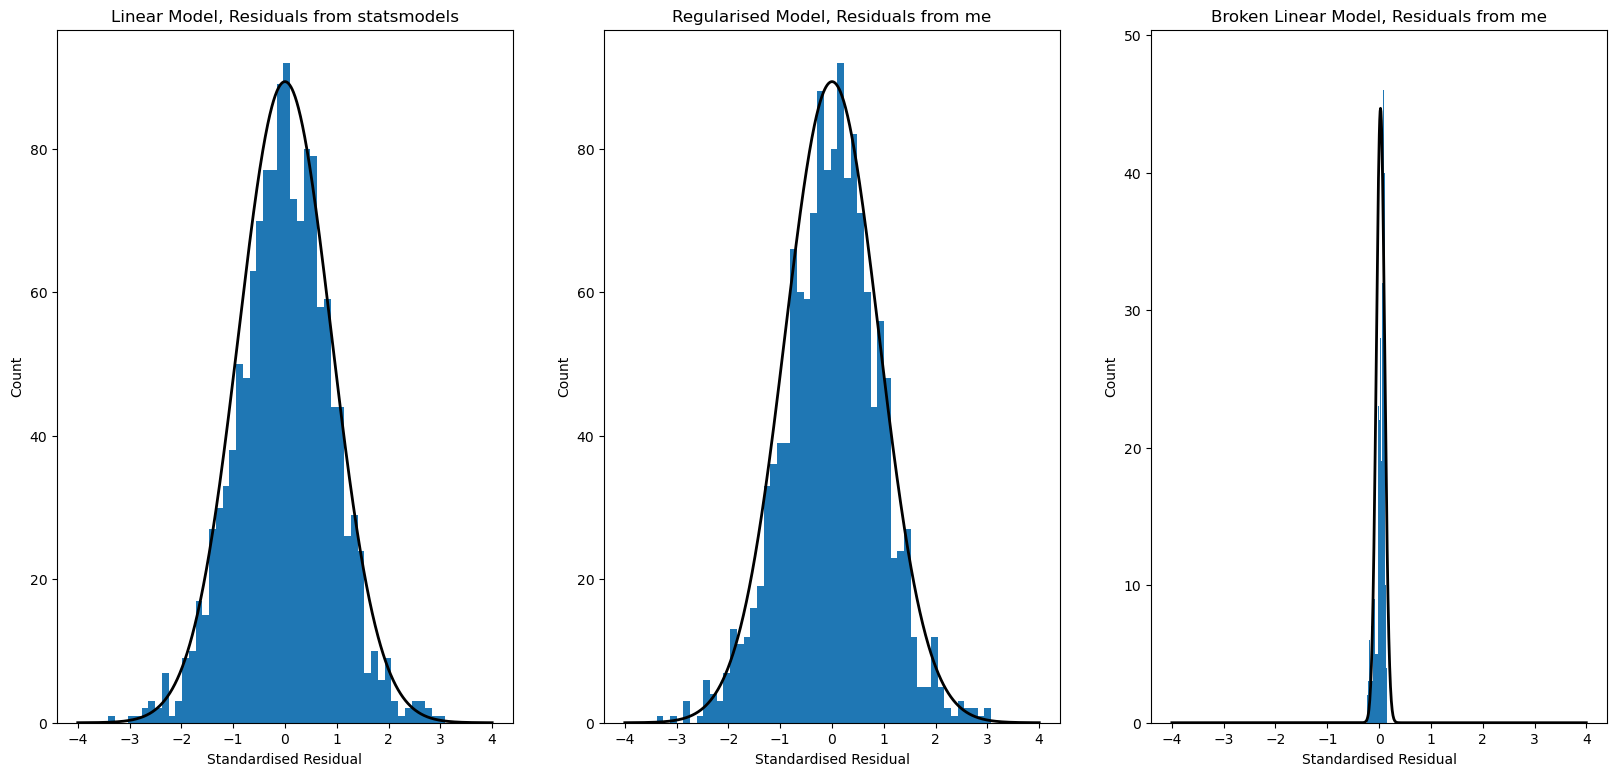

In [6]:
# small function to plot a bell curve over a histgoram of residuals
#  ax - axis to drawn on
#  residuals - the residuals we're comapring to
#  bins - number of histogram bins in the underlying histogram
# this function is assuming the model (and thus residuals) are standardised
def draw_gaussian(ax, residuals, bins):
    # get some x's - from -4 to +4 standard deviations
    x = numpy.linspace(-4,4,1000)
    # comptue the width of the bins and the scale factor, to help the Gaussian line up
    # with the height of the histogram
    binwidth = 8 / bins
    scale_factor = len(residuals) * binwidth
    # compute mean and std.dev of the residuals
    sigma = numpy.std(residuals)
    mu = numpy.mean(residuals)
    # draw a gaussian
    ax.plot(x, stats.norm.pdf((x-mu)/sigma)*scale_factor, color='black', linewidth=2, label='normal')

fig = plt.figure(figsize=[20, 9])

ax = fig.add_subplot(1, 3, 1)
ax.hist(linear_model.resid, 50)
draw_gaussian(ax, linear_model.resid, 50)
ax.set_xlabel('Standardised Residual')
ax.set_ylabel('Count')
ax.set_title('Linear Model, Residuals from statsmodels')

ax = fig.add_subplot(1, 3, 2)
ax.hist(y_train_std.reshape(-1) - regularised_model.predict(X_train_std), 50)
draw_gaussian(ax, y_train_std.reshape(-1) - regularised_model.predict(X_train_std), 50)
ax.set_xlabel('Standardised Residual')
ax.set_ylabel('Count')
ax.set_title('Regularised Model, Residuals from me')

ax = fig.add_subplot(1, 3, 3)
ax.hist(y_broken_train.reshape(-1) - linear_model_broken.predict(X_broken_train), 50)
draw_gaussian(ax, y_broken_train.reshape(-1) - linear_model_broken.predict(X_broken_train), 50)
ax.set_xlabel('Standardised Residual')
ax.set_ylabel('Count')
ax.set_title('Broken Linear Model, Residuals from me')


**What's it show?**
Much the same as the qq-plot, it shows how well the residuals follow a Gaussian distribution. This time we have tha histogram and we can compare that to the ideal bell curve.

**When would you use it?**
Whenever you'd use a qq-plot. I think that the qq-plot makes it slightly easier to compare to a Gaussian distribution, but the histogram makes it a bit easier to identify what type of distribution you're looking at if it's not Gaussian.

**What does it not show?**
Like the qq-plot, it doesn't show much in relation to the model's underlying accuracy.

### Predictions vs Residuals Scatter Plots

Text(0.5, 1.0, 'Broken Linear Model, Residuals from me')

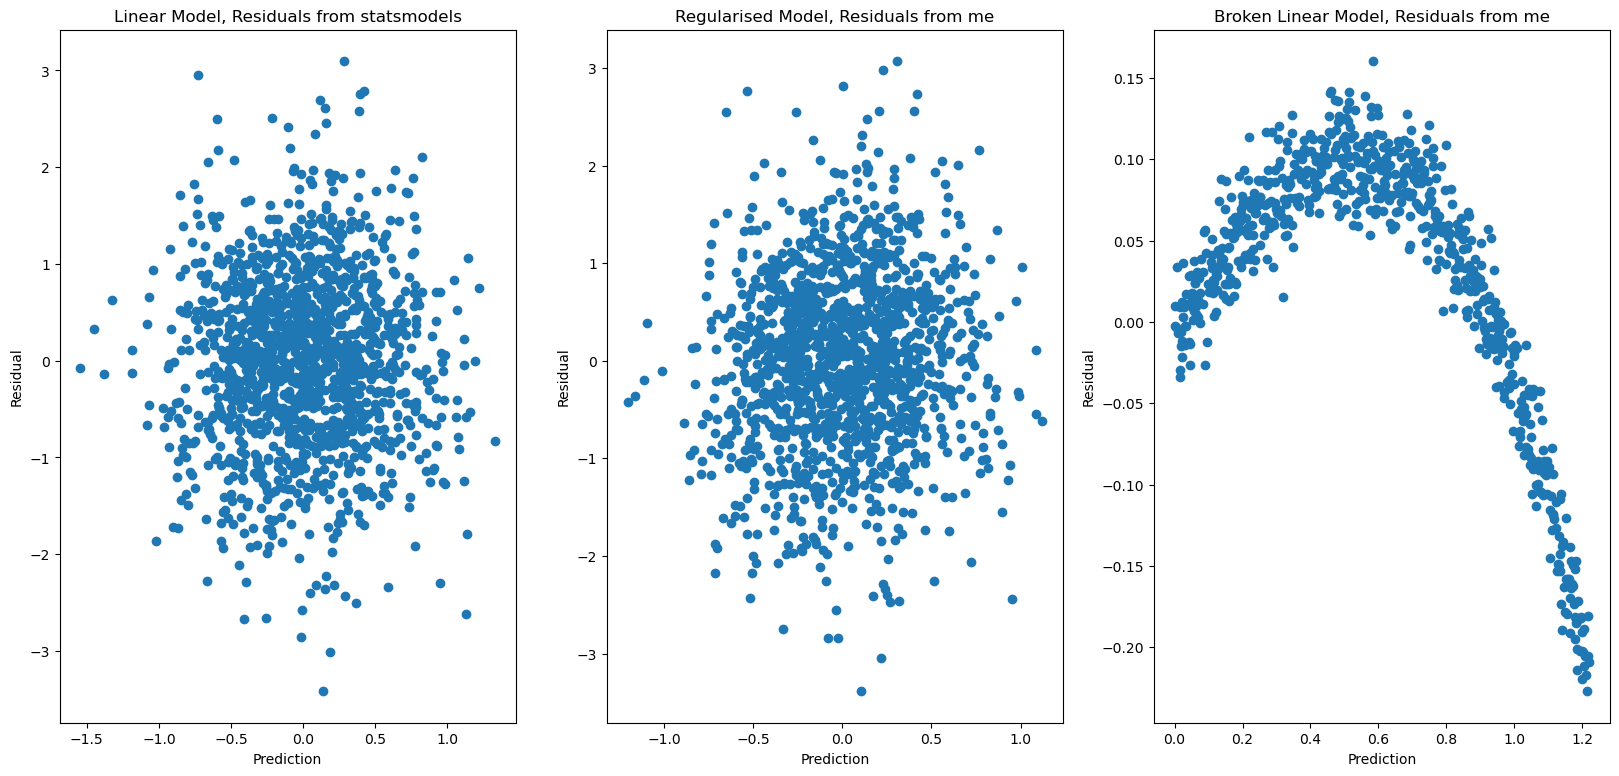

In [7]:
fig = plt.figure(figsize=[20, 9])

ax = fig.add_subplot(1, 3, 1)
ax.scatter(pred_linear_train, linear_model.resid)
ax.set_xlabel('Prediction')
ax.set_ylabel('Residual')
ax.set_title('Linear Model, Residuals from statsmodels')

ax = fig.add_subplot(1, 3, 2)
ax.scatter(pred_regular_train, y_train_std.reshape(-1) - regularised_model.predict(X_train_std))
ax.set_xlabel('Prediction')
ax.set_ylabel('Residual')
ax.set_title('Regularised Model, Residuals from me')

ax = fig.add_subplot(1, 3, 3)
ax.scatter(linear_model_broken.predict(X_broken_train), y_broken_train.reshape(-1) - linear_model_broken.predict(X_broken_train))
ax.set_xlabel('Prediction')
ax.set_ylabel('Residual')
ax.set_title('Broken Linear Model, Residuals from me')

**What's it show?**
The distribution of the residuals with respect to the predictions. We're looking if the distribution is constant across the range of the predictions.

**When would you use it?**
Like the qq-plot (and histogram of residuals), we're using this to check model assumptions, but this time it's helping us check for homoscedacity. Weird shapes here can also give some indication of the types of issues in the model, but as with the qq-plot that's somewhat outside the scope of CAB420. Speaking of weird shapes, what you see over on the right (with the broken model) is a long was from constant and indicates a problem.

**What does it not show?**
Again like the qq-plot (and histogram of residuals), this plot shows nothing of model accuracy.

### RMSE vs Lambda

Text(0.5, 1.0, 'RMSE as Lambda Changes')

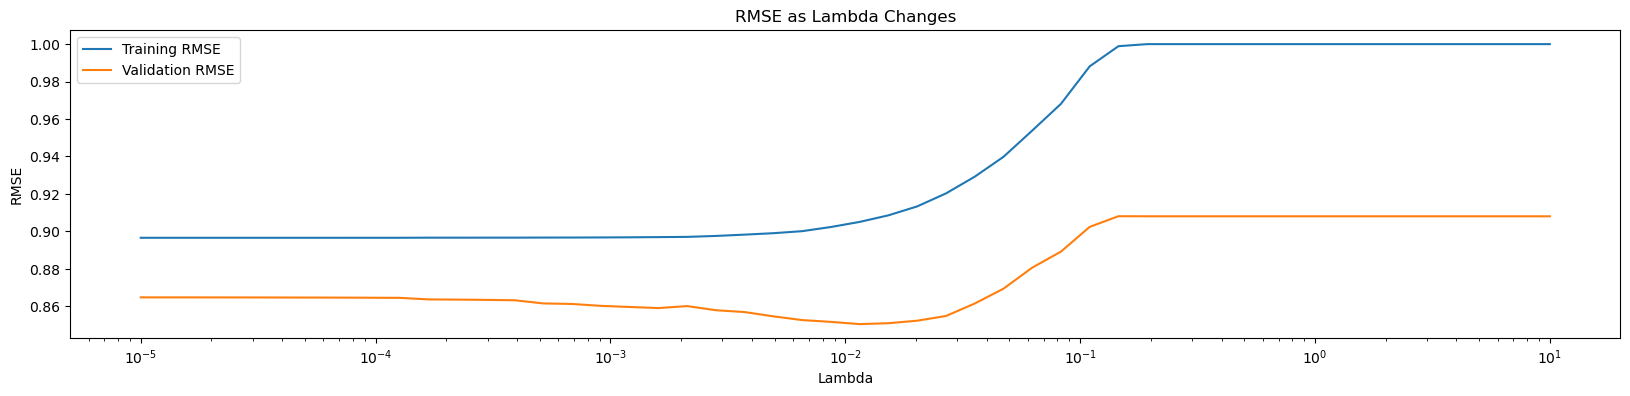

In [8]:
fig = plt.figure(figsize=[20, 4])
ax = fig.add_subplot(1, 1, 1)
ax.plot(lambdas, train_rmse, label='Training RMSE')
ax.plot(lambdas, val_rmse, label='Validation RMSE')
ax.set_xscale('log')
ax.set_xlabel('Lambda')
ax.set_ylabel('RMSE')
ax.legend()
ax.set_title('RMSE as Lambda Changes')

**What's it show?**
How the RMSE on the validation set changes with lambda. While we've also got hthe training RMSE shown, we're not interested in that really beyond a sanity check. What we are looking for is the minimum value of the validation RMSE, this indicates the value of lambda that offers the best trade off between variance and bias. In our case, this is around $10^{-2}$, and this is the final lambda that we'd select (or, we'd conduct a finer grained search around that value of lambda). For the training RMSE, we expect that to always increase with lambda, so if we don't see that then we know something weird is going on.

Note the log scale on the x-axis. This is because we've used a log scale for our lambdas. 

For this plot too, we're using LASSO. We can see when the model becomes a constant (i.e. all terms are eliminated) over on the right when the curves become flat.

**When would you use it?**
When fitting a regularised regression model and selecting lambda. 

**What does it not show?**
Nothing in relation to the residuals or model assumptions.

### Coefficient Trace Plots

Text(0.5, 1.0, 'Coefficients vs Lambda')

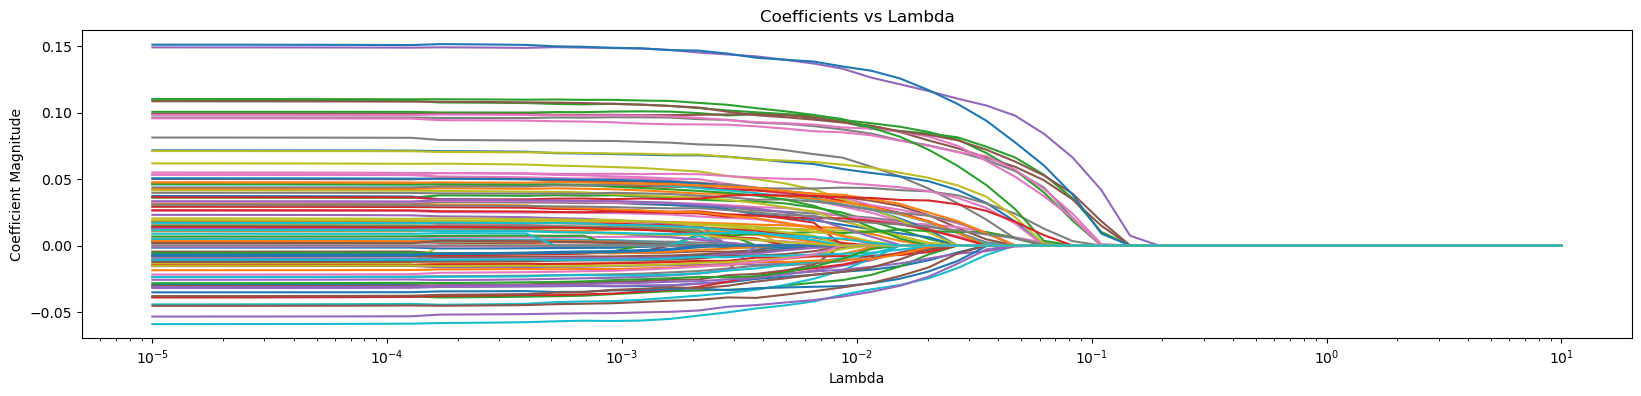

In [9]:
fig = plt.figure(figsize=[20, 4])
ax = fig.add_subplot(1, 1, 1)
ax.plot(lambdas, coeff)
ax.set_xscale('log')
ax.set_xlabel('Lambda')
ax.set_ylabel('Coefficient Magnitude')
ax.set_title('Coefficients vs Lambda')

**What's it show?**
How the coefficients change with lambda. Each coefficient is a line, so we see how some coefficients are reduced before others. 

**When would you use it?**
To look at the interplay between terms, and to help understand the relative importance of terms. With LASSO (which this plot is for) we can also get a sense of how fast terms are removed which can be indicative of the amount of redundancy in the model.  

**What does it not show?**
It shows nothing in relation to model accuracy, or the model assumptions. When you have lots of coefficients, it can also be quite busy.

### Are there any other plots that should be in here?

Plots looking at correlation, either scatter plots that consider correlation between individual terms, or heat maps that do this on mass, have clear applications for regression. These are covered over in part 1 of the plot gallery as these also have a role in visualisation and inspection of data.